In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


### Импорт необходимых библиотек

In [4]:
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.linear_model import LinearRegression

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Фиксируем генератор случайных чисел для воспроизводимости эксперимента

In [5]:
np.random.seed(42)
torch.manual_seed(42)

### Устанавливаем стиль для графиков

In [6]:
sns.set(rc = {'figure.figsize' : (10, 7)}, style='whitegrid', font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

### Загрузка и чтение датасета

In [53]:
df = pd.read_json('auto.json', orient='records')
df

,brand,model,equipment,year,transmission,wheel_drive,price,url
0,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024.0,Вариатор,Передний,2199000.0,https://auto.ru/cars/new/group/chery/tiggo_4_p...
1,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024.0,Механика,Передний,2119000.0,https://auto.ru/cars/new/group/chery/tiggo_4_p...
2,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024.0,Вариатор,Передний,2199000.0,https://auto.ru/cars/new/group/chery/tiggo_4_p...
3,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024.0,Механика,Передний,2120000.0,https://auto.ru/cars/new/group/chery/tiggo_4_p...
4,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024.0,Вариатор,Передний,2200000.0,https://auto.ru/cars/new/group/chery/tiggo_4_p...
...,...,...,...,...,...,...,...,...
7323,,,DLX,2024.0,Автомат,Полный,4000000.0,https://auto.ru/cars/new/group/changan/cs95/23...
7324,Kia,Mohave_I_Рестайлинг_2,None,NaN,None,None,NaN,https://auto.ru/cars/new/group/changan/cs95/23...
7325,Kia,Mohave_I_Рестайлинг_2,None,NaN,None,None,NaN,https://auto.ru/cars/new/group/changan/cs95/23...
7326,Kia,Mohave_I_Рестайлинг_2,None,NaN,None,None,NaN,https://auto.ru/cars/new/group/changan/cs95/23...


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7328 entries, 0 to 7327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         7328 non-null   object 
 1   model         7328 non-null   object 
 2   equipment     7238 non-null   object 
 3   year          7238 non-null   float64
 4   transmission  7238 non-null   object 
 5   wheel_drive   7238 non-null   object 
 6   price         7238 non-null   float64
 7   url           7328 non-null   object 
dtypes: float64(2), object(6)
memory usage: 458.1+ KB


### Удаление строк с пустым значением марки

In [55]:
df = df[~(df['brand']=='')]

### Посчитаем количество нулевых значений по столбцам

In [56]:
df.isnull().sum()

brand            0
model            0
equipment       88
year            88
transmission    88
wheel_drive     88
price           88
url              0
dtype: int64

### Удаляем строки с пропущенным значением цены
Не имеет смыла заменять отсутвующие значения на средние или моды, так как эти строки заполнены лишь по признакам бренда и модели

In [57]:
df = df.dropna(subset=['price'])

In [58]:
df.isnull().sum()

brand           0
model           0
equipment       0
year            0
transmission    0
wheel_drive     0
price           0
url             0
dtype: int64

### Проверим, есть ли в датасете дубликаты и при необходимости удалим их 

In [59]:
duplicates = df.duplicated(keep='last')
duplicates_df = df[duplicates]
duplicates_df

,brand,model,equipment,year,transmission,wheel_drive,price,url
109,Changan,CS95_I_Рестайлинг_2,DLX,2023.0,Автомат,Полный,4191000.0,https://auto.ru/cars/new/group/changan/cs95/23...
110,Changan,CS95_I_Рестайлинг_2,DLX,2023.0,Автомат,Полный,3990000.0,https://auto.ru/cars/new/group/changan/cs95/23...
111,Changan,CS95_I_Рестайлинг_2,DLX,2023.0,Автомат,Полный,4199900.0,https://auto.ru/cars/new/group/changan/cs95/23...
112,Changan,CS95_I_Рестайлинг_2,DLX,2023.0,Автомат,Полный,4199900.0,https://auto.ru/cars/new/group/changan/cs95/23...
113,Changan,CS95_I_Рестайлинг_2,DLX,2024.0,Автомат,Полный,4229900.0,https://auto.ru/cars/new/group/changan/cs95/23...
...,...,...,...,...,...,...,...,...
6937,Nio,ES8_II,Signature,2023.0,Заряд на 605 км,Полный,13140000.0,https://auto.ru/cars/new/group/nio/es8/2352526...
6938,Nio,ES8_II,Signature,2024.0,Заряд на 605 км,Полный,12850000.0,https://auto.ru/cars/new/group/nio/es8/2352526...
6939,Nio,ES8_II,Executive,2023.0,Заряд на 605 км,Полный,8500000.0,https://auto.ru/cars/new/group/nio/es8/2352526...
6940,Nio,ES8_II,Signature,2023.0,Заряд на 605 км,Полный,13140000.0,https://auto.ru/cars/new/group/nio/es8/2352526...


In [60]:
df = df.drop_duplicates()

### Преобразуем значения вещественных столбцов в целочисленный тип

In [61]:
df['year'] = df['year'].astype('int64')
df['price'] = df['price'].astype('int64')

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6184 entries, 0 to 7263
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         6184 non-null   object
 1   model         6184 non-null   object
 2   equipment     6184 non-null   object
 3   year          6184 non-null   int64 
 4   transmission  6184 non-null   object
 5   wheel_drive   6184 non-null   object
 6   price         6184 non-null   int64 
 7   url           6184 non-null   object
dtypes: int64(2), object(6)
memory usage: 434.8+ KB


**В итоге избавились от строк с пропущенными значениями цены, строк с пропущенными значениями марки, удалили дубликаты и преобразовали колонки с вещественным типом данных в целочисленный. После очистки данных можно приступать к разведочному анализу (EDA)**

### Посмотрим на сводную статистику по числовым и качественым признакам

In [63]:
df.describe()

,year,price
count,6184.000000,6.184000e+03
mean,2023.549483,5.621977e+06
std,0.576770,5.987405e+06
min,2021.000000,9.310000e+05
25%,2023.000000,2.599000e+06
50%,2024.000000,3.599500e+06
75%,2024.000000,5.600000e+06
max,2024.000000,5.650000e+07


In [64]:
df.describe(include = ['object'])

,brand,model,equipment,transmission,wheel_drive,url
count,6184,6184,6184,6184,6184,6184
unique,59,210,363,23,3,6184
top,Lada,(ВАЗ)_Granta_I_Рестайлинг,Luxury,Автомат,Передний,https://auto.ru/cars/new/group/chery/tiggo_4_p...
freq,500,74,416,2531,3184,1


In [65]:
df.drop(columns='url', inplace=True)
df.head()

,brand,model,equipment,year,transmission,wheel_drive,price
0,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Вариатор,Передний,2199000
1,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Механика,Передний,2119000
2,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Вариатор,Передний,2199000
3,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Механика,Передний,2120000
4,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Вариатор,Передний,2200000


## Проанализируем признаки по отдельности 

### Уникальные значения и частота их появления в признаках

In [66]:
df['brand'].value_counts()

brand
Lada             500
Changan          408
CHERY            376
Geely            262
Haval            260
EXEED            257
Kia              207
Hyundai          202
Dongfeng         200
Mercedes-Benz    185
Mazda            165
Toyota           145
Zeekr            142
JAC              142
Hongqi           137
Kaiyi            123
OMODA            123
LiXiang          116
Skoda            112
Audi             110
Jetour           110
Nio              104
BAIC              88
Peugeot           88
Seres             85
SWM               84
GAC               84
Jaecoo            83
Land              79
УАЗ               74
Voyah             72
Belgee            71
Porsche           70
BMW               69
Jetta             68
HiPhi             55
Great             54
Livan             51
FAW               49
Москвич           47
Lexus             44
Mitsubishi        44
Solaris           43
MG                42
Xcite             37
Ora               37
Forthing          37
Tank   

Какие марки и в каком количестве представлены в датасете

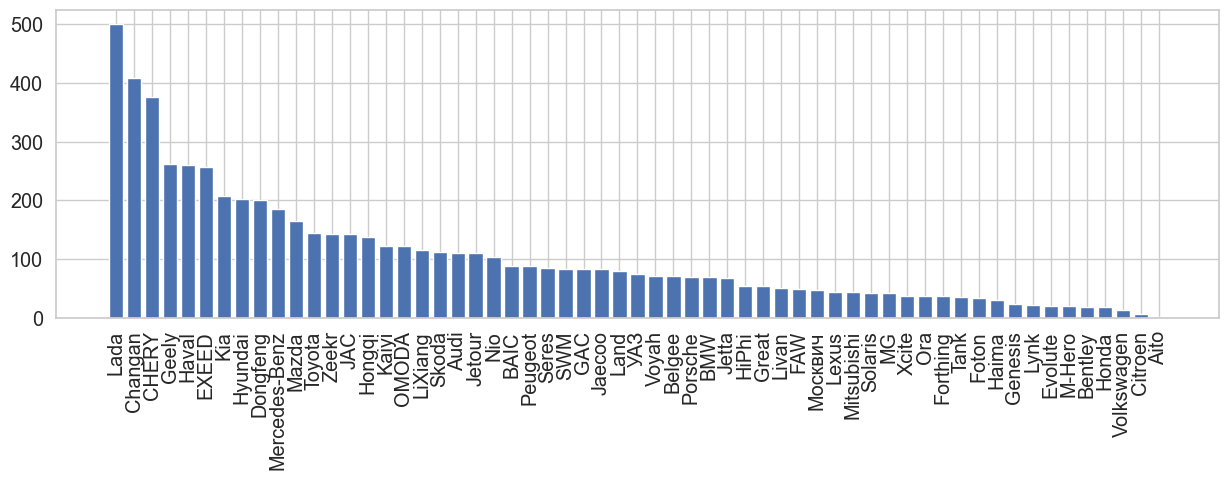

In [67]:
data = df['brand'].value_counts()
names = data.index
values = data.values
plt.figure(figsize=(15, 4))
plt.bar(names, values)
plt.xticks(rotation=90);

In [68]:
df['transmission'].value_counts()

transmission
Автомат            2531
Робот              1891
Вариатор            768
Механика            644
Заряд на 500 км      47
Заряд на 512 км      39
Заряд на 705 км      36
Заряд на 655 км      33
Заряд на 605 км      29
Заряд на 822 км      26
Заряд на 560 км      23
Заряд на 575 км      21
Заряд на 635 км      18
Заряд на 616 км      15
Заряд на 430 км      15
Заряд на 625 км      14
Заряд на 770 км      13
Заряд на 600 км       7
Заряд на 660 км       6
Заряд на 550 км       3
Заряд на 702 км       2
Заряд на 688 км       2
Заряд на 534 км       1
Name: count, dtype: int64

In [69]:
df.loc[~(df['transmission']=='Автомат') & ~(df['transmission']=='Робот') & ~(df['transmission']=='Вариатор') & ~(df['transmission']=='Механика'), 'transmission'] = 'Электро'
df['transmission'].value_counts()

transmission
Автомат     2531
Робот       1891
Вариатор     768
Механика     644
Электро      350
Name: count, dtype: int64

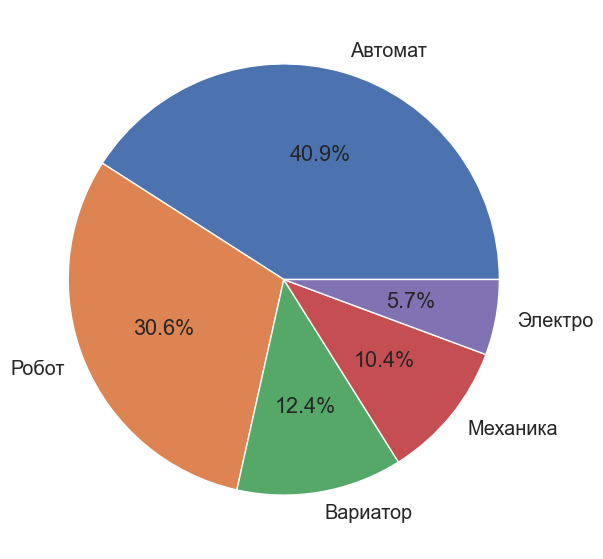

In [70]:
data = df['transmission'].value_counts()
names = data.index
values = data.values
plt.pie(values, labels=names, autopct='%.1f%%');

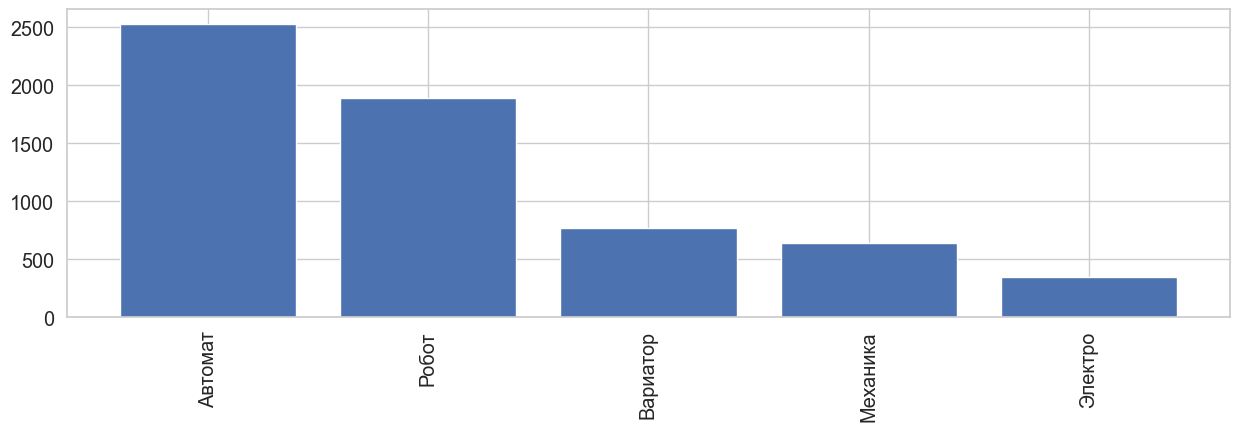

In [71]:
data = df['transmission'].value_counts()
names = data.index
values = data.values
plt.figure(figsize=(15, 4))
plt.bar(names, values)
plt.xticks(rotation=90);

In [72]:
df['wheel_drive'].value_counts()

wheel_drive
Передний    3184
Полный      2981
Задний        19
Name: count, dtype: int64

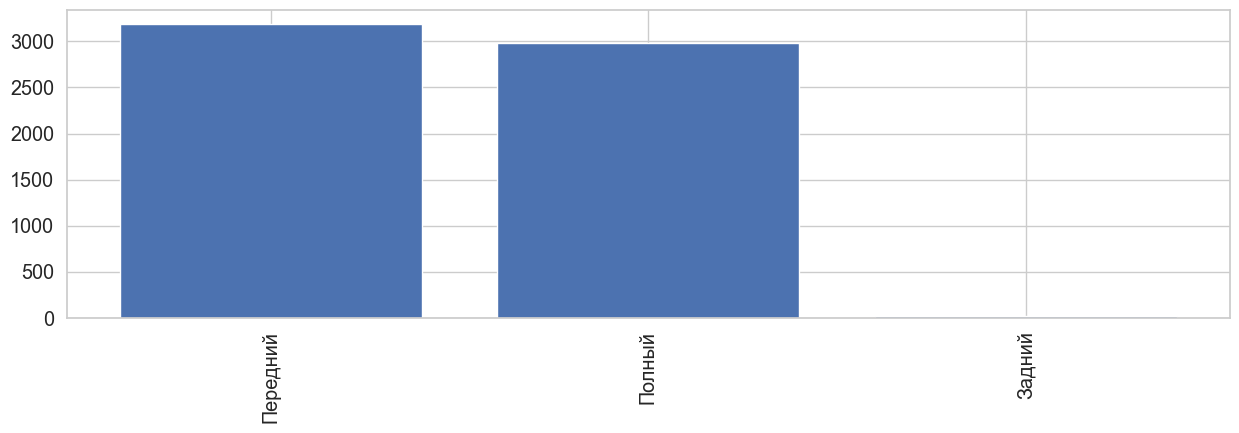

In [75]:
data = df['wheel_drive'].value_counts()
names = data.index
values = data.values
plt.figure(figsize=(15, 4))
plt.bar(names, values)
plt.xticks(rotation=90);

In [76]:
df['year'].value_counts()

year
2024    3647
2023    2302
2022     221
2021      14
Name: count, dtype: int64

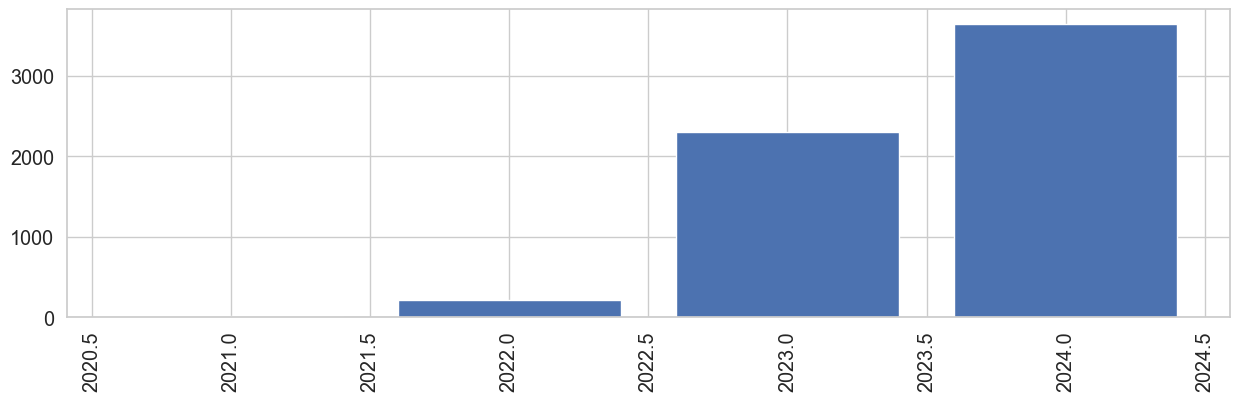

In [77]:
data = df['year'].value_counts()
names = data.index
values = data.values
plt.figure(figsize=(15, 4))
plt.bar(names, values)
plt.xticks(rotation=90);

### Сводная таблица (pivot_table)
Агрегация столбца цены (максимальное значение) на основе столбца года. Группировка по индексу на основе столцов бренда и привода

In [78]:
df_pivot = pd.pivot_table(df,
               index=['brand', 'wheel_drive'],
               values=['price'],
               columns=['year'],
               aggfunc=['min', 'max'],
               fill_value=0)
df_pivot
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df_pivot)

min                               max            \
                    price                             price             
year                 2021     2022     2023      2024  2021      2022   
brand   wheel_drive                                                     
Aito    Полный          0        0  4950000         0     0         0   
Audi    Полный          0  8032990  8495000  11500000     0  16160000   
BAIC    Передний        0        0  2950000   3120000     0         0   
        Полный          0        0  4050000   4350000     0         0   
BMW     Полный          0        0  9797825  12426000     0         0   
...                   ...      ...      ...       ...   ...       ...   
Xcite   Передний        0        0        0   2495500     0         0   
Zeekr   Задний          0        0        0   5800000     0         0   
        Полный          0        0  3690000   4900000     0         0   
Москвич Передний        0        0        0   1700000     0         0   
УАЗ     Полный          0        0  1425600   1435000     0         0   

                                         
                                         
year                     2023      2024  
brand   wheel_drive                      
Aito    Полный        4950000         0  
Audi    Полный       19250000  19411832  
BAIC    Передний      3250000   3410000  
        Полный        4400000   4500000  
BMW     Полный       16830000  23500000  
...                       ...       ...  
Xcite   Передний            0   2636000  
Zeekr   Задний              0   5800000  
        Полный       17990000  19000000  
Москвич Передний            0   1900000  
УАЗ     Полный        1620000   2190000  

[86 rows x 8 columns]

In [79]:
df.groupby('brand').agg({'price': ['min', 'mean', 'max']})

price                        
                    min          mean       max
brand                                          
Aito            4950000  4.950000e+06   4950000
Audi            8032990  1.436510e+07  19411832
BAIC            2950000  3.728551e+06   4500000
BMW             9797825  1.432505e+07  23500000
Belgee          2305990  2.804610e+06   3234990
Bentley        31850000  4.854002e+07  56500000
CHERY           2095700  3.357730e+06   4989280
Changan         2117528  3.203154e+06   4627867
Citroen         3699000  3.802333e+06   3934000
Dongfeng        1635000  2.895075e+06   3990000
EXEED           2800000  4.445663e+06   6700000
Evolute         3360000  3.438000e+06   3490000
FAW             2190000  2.835698e+06   5497020
Forthing        2600000  3.405649e+06   5500000
Foton           3000000  3.578951e+06   3900000
GAC             2199000  4.151762e+06   6500000
Geely           2119990  3.342051e+06   4994990
Genesis        11720000  1.480667e+07  16790000
Great           3099000  3.498815e+06   3789000
Haima           3400000  3.595000e+06   3850000
Haval           1999000  3.021092e+06   5299000
HiPhi           7200000  9.288905e+06  12700000
Honda           4900000  6.516444e+06   7590000
Hongqi          3990000  5.124743e+06   9400000
Hyundai         2400000  5.792408e+06  10300000
JAC             1790000  2.723916e+06   3799000
Jaecoo          3049000  4.183234e+06   5454935
Jetour          2489900  3.459506e+06   3999000
Jetta           1790000  2.496119e+06   3203000
Kaiyi           2039000  2.504952e+06   3475900
Kia             2600000  4.077177e+06   6570000
Lada             931000  1.536252e+06   2394000
Land           16850000  2.886943e+07  41900000
Lexus           8100000  2.191518e+07  30990000
LiXiang         6290000  7.408445e+06   9690000
Livan           1889900  2.474208e+06   2749900
Lynk            7600000  7.777273e+06   7990000
M-Hero         15990000  1.695250e+07  18190000
MG              1698000  2.279429e+06   2548000
Mazda           3250000  5.291528e+06   9290000
Mercedes-Benz   6348425  1.925793e+07  36003000
Mitsubishi      4490000  5.671977e+06   6299000
Nio             7900000  1.130010e+07  13140000
OMODA           1999000  2.578744e+06   3267035
Ora             3663000  3.736969e+06   3999000
Peugeot         2999000  4.231330e+06   5025000
Porsche        16890000  2.388757e+07  37990000
SWM             2130000  2.301889e+06   2769260
Seres           5490000  6.638744e+06   8100000
Skoda           2850000  4.201298e+06   5690000
Solaris         1889000  2.335270e+06   3099000
Tank            6299000  6.693722e+06   7699000
Toyota          3570000  6.212566e+06  18500000
Volkswagen      2690000  3.773076e+06   4800000
Voyah           4990000  7.773056e+06  13990000
Xcite           2495500  2.555216e+06   2636000
Zeekr           3690000  7.195252e+06  19000000
Москвич         1700000  1.762340e+06   1900000
УАЗ             1425600  1.766792e+06   2190000

In [80]:
df.groupby('equipment').agg({'price': ['min', 'mean', 'max']})

price                        
                         min          mean       max
equipment                                           
#CLUB'24             1089000  1.177498e+06   1364000
#CLUB'24 EnjoY Pro   1184000  1.206500e+06   1214000
#Club                1119000  1.166333e+06   1190000
270T TOP             4899000  4.899000e+06   4899000
300 d 4MATIC        16768949  1.742729e+07  18222545
...                      ...           ...       ...
Премиум             18500000  1.850000e+07  18500000
Премиум Плюс        15500000  1.559950e+07  15699000
Престиж             12490000  1.249500e+07  12500000
Стандарт плюс        1700000  1.759348e+06   1770000
Экспедиция           1820000  1.834286e+06   1920000

[363 rows x 3 columns]

## Добавим дополнительный признак, который будет определять, к какой ценовой категории относится автомобиль

In [81]:
df.loc[df['price']<=5_000_000, 'category'] = 'Эконом'
df.loc[(df['price']>5_000_000) & (df['price']<=15_000_000), 'category'] = 'Комфорт'
df.loc[(df['price']>15_000_000) & (df['price']<30_000_000), 'category'] = 'Бизнес'
df.loc[df['price']>=30_000_000, 'category'] = 'Премиум'
df.head()

,brand,model,equipment,year,transmission,wheel_drive,price,category
0,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Вариатор,Передний,2199000,Эконом
1,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Механика,Передний,2119000,Эконом
2,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Вариатор,Передний,2199000,Эконом
3,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Механика,Передний,2120000,Эконом
4,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Вариатор,Передний,2200000,Эконом


In [82]:
df['category'].value_counts()

category
Эконом     4387
Комфорт    1321
Бизнес      416
Премиум      60
Name: count, dtype: int64

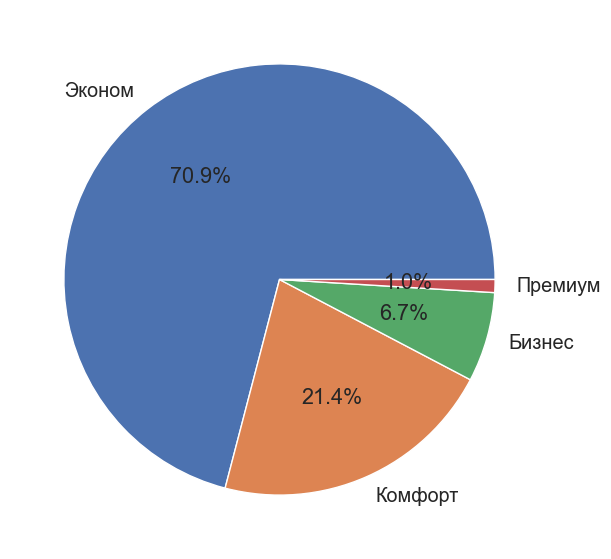

In [83]:
data = df['category'].value_counts()
names = data.index
values = data.values
plt.pie(values, labels=names, autopct='%.1f%%');

Сохраним обработанный датасет, чтоб не проходить все предыдущие шаги заново в случае допущения ошибок на следующих этапах

In [85]:
clean_df = 'cleaned_auto.json'
df.to_json(clean_df)

In [115]:
df = pd.read_json('cleaned_auto.json', orient='records')
df

,brand,model,equipment,year,transmission,wheel_drive,price,category
0,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Вариатор,Передний,2199000,Эконом
1,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Механика,Передний,2119000,Эконом
2,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Вариатор,Передний,2199000,Эконом
3,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Механика,Передний,2120000,Эконом
4,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Вариатор,Передний,2200000,Эконом
...,...,...,...,...,...,...,...,...
7259,Lada,(ВАЗ)_Vesta_SW_Sportline_I_Рестайлинг_(NG),Sportline,2024,Механика,Передний,2364000,Эконом
7260,Lada,(ВАЗ)_Vesta_SW_Sportline_I_Рестайлинг_(NG),Sportline'24 Black,2024,Механика,Передний,2392900,Эконом
7261,Lada,(ВАЗ)_Vesta_SW_Sportline_I_Рестайлинг_(NG),Sportline,2024,Механика,Передний,2364000,Эконом
7262,Lada,(ВАЗ)_Vesta_SW_Sportline_I_Рестайлинг_(NG),Sportline,2024,Механика,Передний,2364000,Эконом


## Плотность распределения цен в датасете

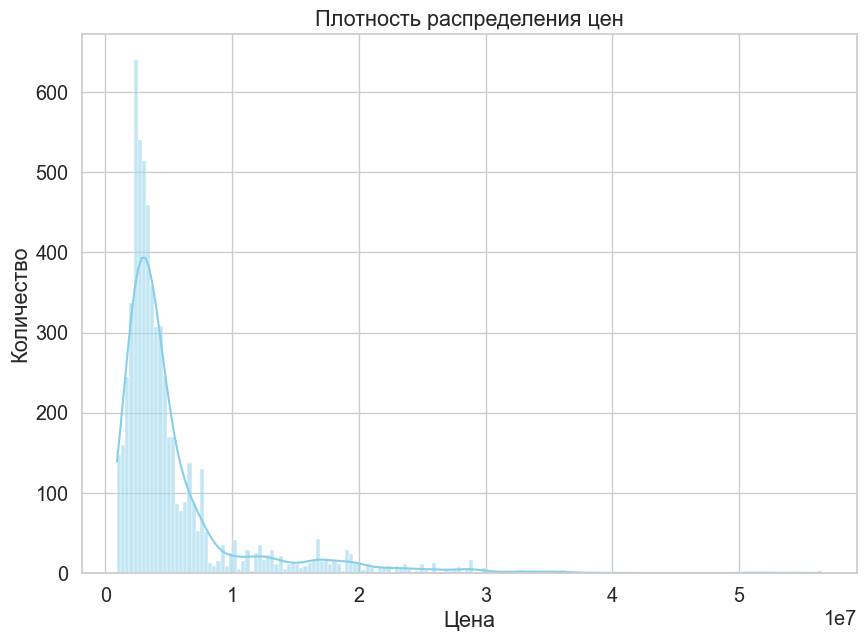

In [87]:
sns.histplot(df['price'], kde=True, color='skyblue')
plt.title('Плотность распределения цен')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()

Основная масса новых автомобилей в городе Санкт-Петербург находится в пределах до 10 миллионов рублей. Также имеются автомобили свыше 50 миллионов. Для уменьшения влияния выбросов на статистику проведем некоторые преобразования столбца с признаком цены. 

In [88]:
df['price'].min(), df['price'].max()

(931000, 56500000)

### Выявление выбросов на основе Z-score

In [89]:
z = np.abs(stats.zscore(df['price']))
outliers = df['price'][z > 3]
outliers.value_counts()

price
28990416    6
25793455    5
28750320    5
27900000    4
24990000    4
           ..
25300000    1
25550000    1
25806000    1
26058000    1
29500000    1
Name: count, Length: 114, dtype: int64

In [90]:
outliers.count()

155

Получили 155 выбросов, где значение цены отклоняется от среднего на 3 стандартных отклонения. Удаление может
привести к потере данных и потенциальной погрешности анализа. Проведем винсоризацию

### Винсоризация столбца price

In [91]:
df['price'].mean()

5621976.968305304

In [92]:
from scipy.stats.mstats import winsorize
df['price'] = winsorize(df['price'], limits=[0.00, 0.005])

In [93]:
df['price'].mean()

5576014.452296249

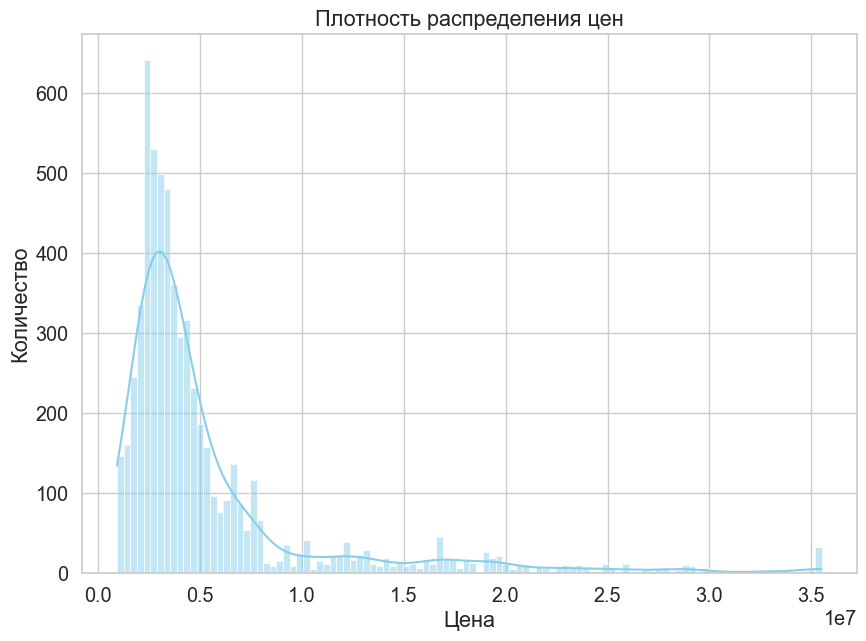

In [94]:
sns.histplot(df['price'], kde=True, color='skyblue')
plt.title('Плотность распределения цен')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()

In [95]:
df['price'].min(), df['price'].max()

(931000, 35500000)

## Преобразование данных с помощью логарифмической функции

In [103]:
df_log = df.copy(deep=True)
df_log['price'] = np.log1p(df_log['price'])
df_log.head()

,brand,model,equipment,year,transmission,wheel_drive,price,category
0,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Вариатор,Передний,14.603514,Эконом
1,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Механика,Передний,14.566455,Эконом
2,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Вариатор,Передний,14.603514,Эконом
3,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Механика,Передний,14.566927,Эконом
4,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Вариатор,Передний,14.603968,Эконом


In [104]:
df_log['price'].min(), df_log['price'].max()

(13.744015630372484, 17.849751213815786)

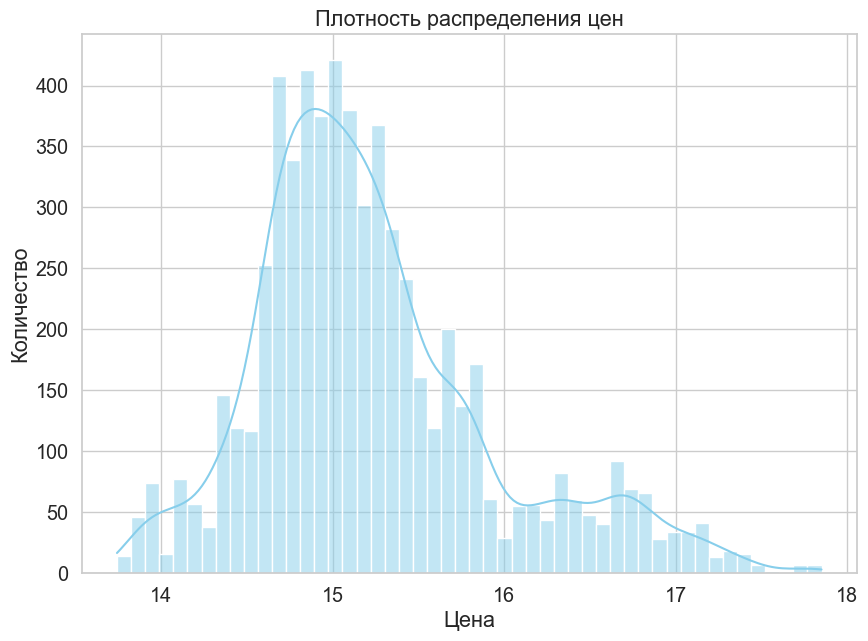

In [105]:
sns.histplot(df_log['price'], kde=True, color='skyblue')
plt.title('Плотность распределения цен')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()

Получили распределение, близкое к нормальному. Можно приступать к статистическому анализу

In [84]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=df['price'],
                         groups=df['wheel_drive'],
                         alpha=0.05)
print(tukey)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
 group1   group2     meandiff   p-adj      lower        upper     reject
------------------------------------------------------------------------
  Задний Передний -3247759.0048 0.0129 -5935587.8438 -559930.1659   True
  Задний   Полный  2261940.8655 0.1191  -426430.7967 4950312.5278  False
Передний   Полный  5509699.8704    0.0  5211995.3062 5807404.4345   True
------------------------------------------------------------------------


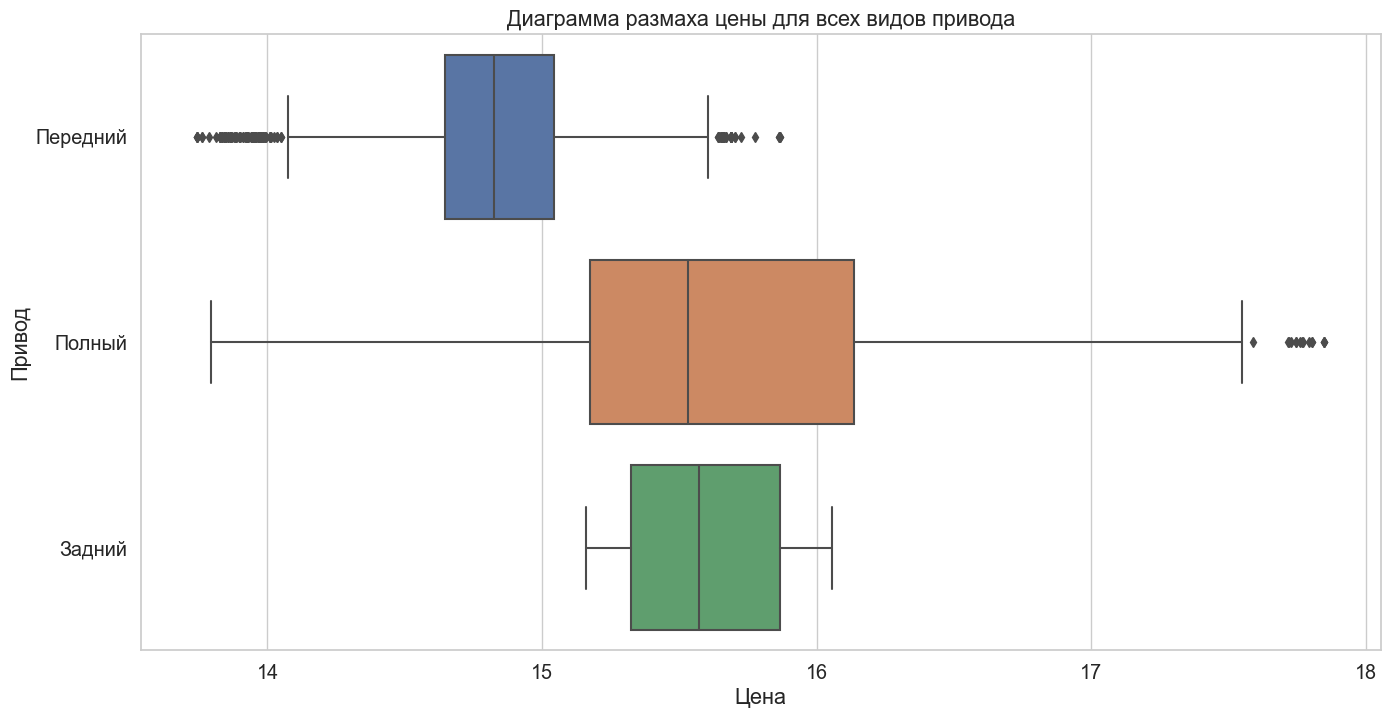

In [106]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df_log['price'], y=df_log['wheel_drive'], whis=1.5)
plt.xlabel('Цена')
plt.ylabel('Привод')
plt.title('Диаграмма размаха цены для всех видов привода');

In [32]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [38]:
df_anova = pd.DataFrame({'fA': df['brand'], 'fB': df['wheel_drive'], 'values': df['price']})
lm_model = ols('values~C(fA)*C(fB)',data=df_anova).fit()
table = sm.stats.anova_lm(lm_model, typ=2)
table

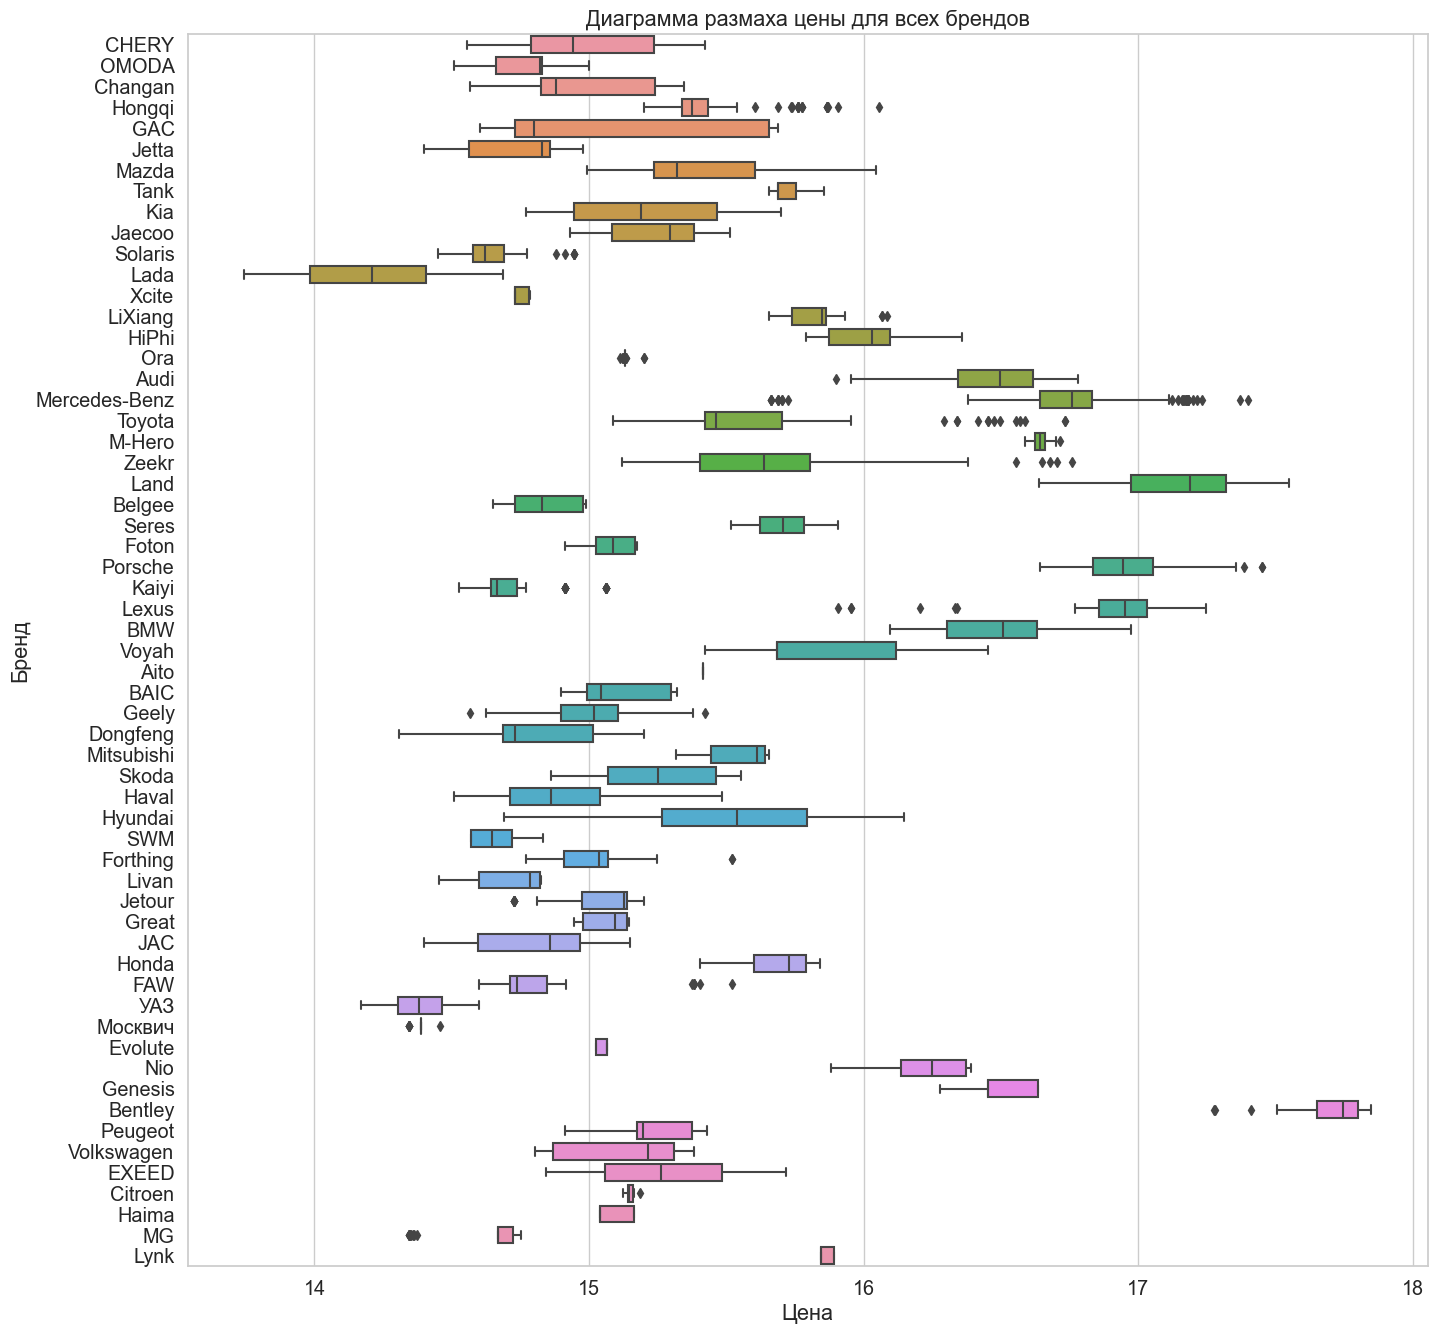

In [107]:
plt.figure(figsize=(16, 16))
sns.boxplot(x=df_log['price'], y=df_log['brand'], whis=1.5)
plt.xlabel('Цена')
plt.ylabel('Бренд')
plt.title('Диаграмма размаха цены для всех брендов');

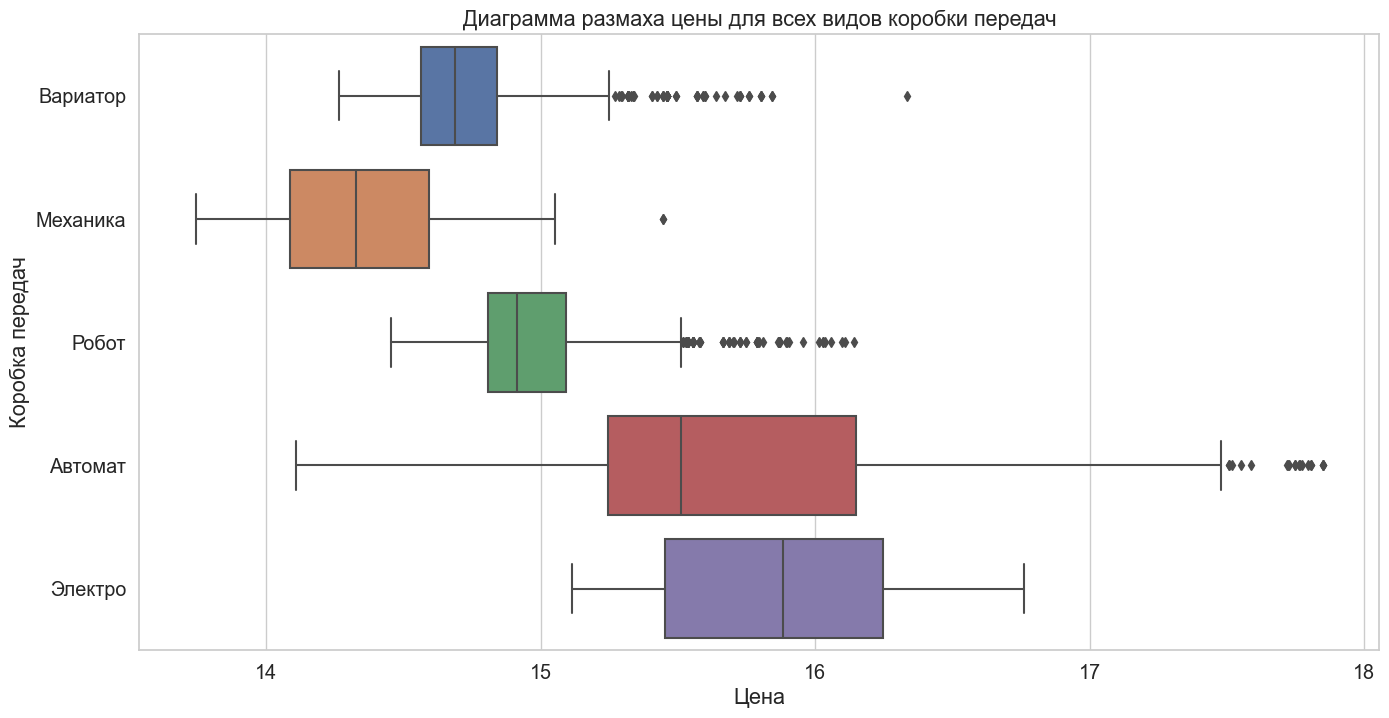

In [108]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df_log['price'], y=df_log['transmission'], whis=1.5)
plt.xlabel('Цена')
plt.ylabel('Коробка передач')
plt.title('Диаграмма размаха цены для всех видов коробки передач');

Посмотрим на парные зависимости цены от категориальных признаков на совмещенном графике распределения

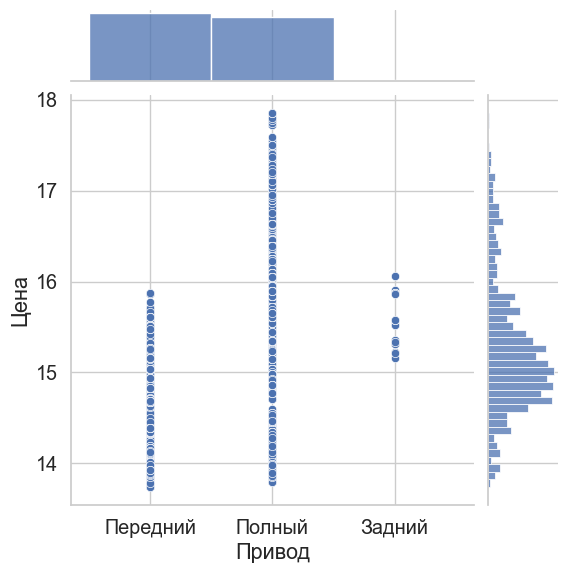

In [44]:
sns.jointplot(x = df_log['wheel_drive'], y = df_log['price'])
plt.xlabel('Привод')
plt.ylabel('Цена');

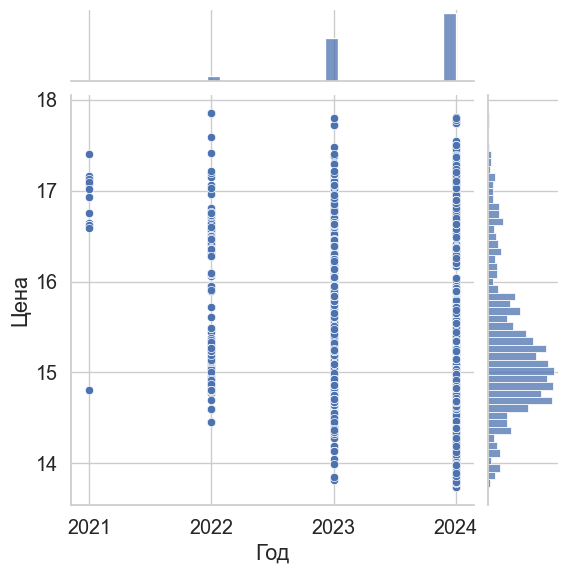

In [45]:
sns.jointplot(x = df_log['year'], y = df_log['price'])
plt.xlabel('Год')
plt.ylabel('Цена');

In [111]:
category_map = {'Эконом' : 1, 'Комфорт' : 2, 'Бизнес' : 3, 'Премиум' : 4}
df['category'] = df['category'].map(category_map)
df.head()

,brand,model,equipment,year,transmission,wheel_drive,price,category
0,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Вариатор,Передний,2199000,1
1,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Механика,Передний,2119000,1
2,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Вариатор,Передний,2199000,1
3,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Механика,Передний,2120000,1
4,CHERY,Tiggo_4_Pro_I_Рестайлинг,Action,2024,Вариатор,Передний,2200000,1


In [112]:
df['category'].value_counts()

category
1    4387
2    1321
3     416
4      60
Name: count, dtype: int64

In [116]:
df_one_hot = pd.get_dummies(df, columns=['brand', 'model', 'equipment', 'transmission', 'wheel_drive'], dtype=int)
df_one_hot.head()

,year,price,category,brand_Aito,brand_Audi,brand_BAIC,brand_BMW,brand_Belgee,brand_Bentley,brand_CHERY,...,equipment_Стандарт плюс,equipment_Экспедиция,transmission_Автомат,transmission_Вариатор,transmission_Механика,transmission_Робот,transmission_Электро,wheel_drive_Задний,wheel_drive_Передний,wheel_drive_Полный
0,2024,2199000,Эконом,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,2024,2119000,Эконом,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
2,2024,2199000,Эконом,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,2024,2120000,Эконом,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
4,2024,2200000,Эконом,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
sns.heatmap(df_one_hot.corr(), annot=True)

In [114]:
df = df.sample(frac=0.1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 618 entries, 5164 to 1289
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         618 non-null    object
 1   model         618 non-null    object
 2   equipment     618 non-null    object
 3   year          618 non-null    int64 
 4   transmission  618 non-null    object
 5   wheel_drive   618 non-null    object
 6   price         618 non-null    int64 
 7   category      618 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 43.5+ KB


Обозначим целевую переменную (цена автомобиля) и признаки

In [117]:
y = df['price']
X = df[['brand', 'model', 'equipment', 'year', 'transmission', 'wheel_drive', 'category']]

Предобработка данных
Разобьем наши данные на обучающую и тестовую выборки в пропорции  80/20

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [119]:
scaler = MinMaxScaler()

In [121]:
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
X_test_scaled = scaler.transform(X_test)

In [123]:
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float)
X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float)

y_train_tensor = torch.tensor(y_train[:, None], dtype=torch.float)
y_test_tensor = torch.tensor(y_test[:, None], dtype=torch.float)

In [23]:
y_test_tensor[12]

tensor(3986000)